In [1]:
import os

In [2]:
dargs = {
    'ROOT_DIR': 'C:/Users/ericotjoa/Desktop/xaia',
    'label_name': 'drybean-sqann',    
    'DRYBEAN_DATA_DIR': 'C:/data/DryBeanDataset/Dry_Bean_Dataset.xlsx',
}

os.chdir(dargs['ROOT_DIR'])

In [3]:
from SQANN.utils.drybean import *
from SQANN.utils.continuous_eval import standard_evaluation_cont, compute_discrete_error
DIRS = manage_dirs_drybean(dargs)

In [4]:
if len(os.listdir(DIRS['DRYBEAN_DATA_OBS_FOLDER_DIR'])) ==0 :
    drybean_reconstruct_data(dargs)
else:
    print('reconstructed data already exist')

reconstructed data already exist


In [5]:
n_train_per_class = 100
df = pd.read_csv(DIRS['REC_TRAIN_DATA_DIR'], index_col=False)
print(df.columns)
print('df.size:',df.size)

columns = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4']
CLASSES = [ 'SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON',  'HOROZ', 'SIRA']
CLASSES_TO_IDX = {
    'SEKER':0, 'BARBUNYA':1, 'BOMBAY':2, 'CALI':3, 'DERMASON':4,  'HOROZ':5, 'SIRA':6
}

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')
df.size: 77129


In [6]:
mean = []
std = []
for col in columns:
    this_mean = np.mean(df[[col]].to_numpy())
    mean.append(this_mean)
    this_std = np.var(df[col].to_numpy())**0.5
    std.append(this_std) 
    print('%-24s'%(str(col)), this_mean, this_std)
    
mean = np.array([mean])
std = np.array([std])
print(mean.shape, std.shape)

Area                     53065.33325986334 29379.482878530296
Perimeter                855.2309728895747 214.38574939336613
MajorAxisLength          320.2309382849401 85.57274302747027
MinorAxisLength          202.2398852047827 45.1598639866432
AspectRation             1.5843569522368004 0.24665637824443598
Eccentricity             0.7514578899076426 0.09114784304263998
ConvexArea               53779.89750936742 29824.887757370874
EquivDiameter            253.08931417621307 59.250989956473965
Extent                   0.7494395971260904 0.049162135649235945
Solidity                 0.9872249618317565 0.004596510502959251
roundness                0.8735512069147143 0.05986048171352723
Compactness              0.7995835045655676 0.06157563440415778
ShapeFactor1             0.006566555822465833 0.001134122986878744
ShapeFactor2             0.001713324121053692 0.0005928982430959338
ShapeFactor3             0.6431253395256294 0.09869742273770211
ShapeFactor4             0.9951098049615792 0

In [7]:
X_train = []
Y_train = []
for c in CLASSES:
    df_temp = df[df['Class']==c]
    X_train.append(df_temp[columns].to_numpy()[:n_train_per_class])
    Y_train.append(df_temp[['Class']].to_numpy().reshape(-1)[:n_train_per_class])
    
X_train = (np.concatenate(X_train) - mean)/std
Y_train = np.concatenate(Y_train)

for c in CLASSES:
    print("%-10s"%(str(c)),sum(Y_train==c))
Y_train = np.array([CLASSES_TO_IDX[x] for x in Y_train])
print('sample Y:',Y_train[::n_train_per_class])
print(X_train.shape)
print(Y_train.shape)

SEKER      100
BARBUNYA   100
BOMBAY     100
CALI       100
DERMASON   100
HOROZ      100
SIRA       100
sample Y: [0 1 2 3 4 5 6]
(700, 16)
(700,)


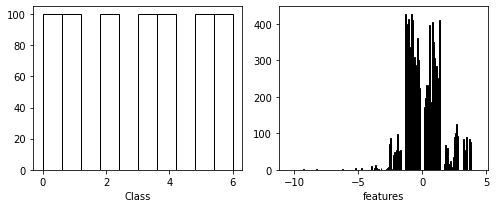

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3))
plt.gcf().add_subplot(1,2,1)
plt.gca().hist(Y_train, fill=False)
plt.gca().set_xlabel('Class')
plt.gcf().add_subplot(1,2,2)
plt.gca().hist(X_train, fill=False)
plt.gca().set_xlabel('features')
plt.tight_layout()
print()

In [9]:
df_test = pd.read_csv(DIRS['REC_TEST_DATA_DIR'], index_col=False)
X_test = []
Y_test = []
for c in CLASSES:
    df_temp = df_test[df_test['Class']==c]
    X_test.append(df_temp[columns].to_numpy())
    Y_test.append(df_temp[['Class']].to_numpy().reshape(-1))
    
X_test = (np.concatenate(X_test) - mean)/std
Y_test = np.concatenate(Y_test)

for c in CLASSES:
    print("%-10s"%(str(c)),sum(Y_test==c))
Y_test = np.array([CLASSES_TO_IDX[x] for x in Y_test])
print('sample Y:',Y_test)
print(X_test.shape)
print(Y_test.shape)

SEKER      675
BARBUNYA   441
BOMBAY     174
CALI       543
DERMASON   1182
HOROZ      643
SIRA       879
sample Y: [0 0 0 ... 6 6 6]
(4537, 16)
(4537,)


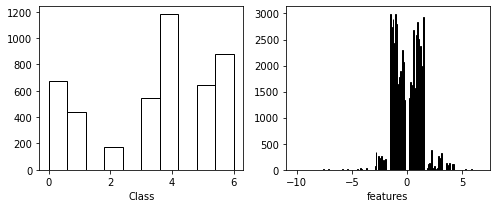

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3))
plt.gcf().add_subplot(1,2,1)
plt.gca().hist(Y_test, fill=False)
plt.gca().set_xlabel('Class')
plt.gcf().add_subplot(1,2,2)
plt.gca().hist(X_test, fill=False)
plt.gca().set_xlabel('features')
plt.tight_layout()
print()

In [11]:
MDE = {} 
# mean discrete error. This is simple error measurement where
# if class prediction is wrong, error is assigned 1, else 0

from sklearn.linear_model import LinearRegression, Ridge,  Lasso
def do_regress(regression, X_train, Y_train, MDE, name):
    model = regression.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    if name is not None:
        MDE[name] = compute_discrete_error(Y_pred,Y_test)
    return MDE

print('linear models...')
MDE = do_regress(LinearRegression(), X_train, Y_train, MDE, 'linear')
MDE = do_regress(Ridge(), X_train, Y_train, MDE,'Ridge')
MDE = do_regress(Lasso(), X_train, Y_train, MDE, 'Lasso')

print('\nSupport vector models...')
from sklearn.svm import LinearSVR, NuSVR, SVR
MDE = do_regress(LinearSVR(), X_train, Y_train, MDE,'LinSVR')
MDE = do_regress(NuSVR(), X_train, Y_train, MDE,'NuSVR')
MDE = do_regress(SVR(), X_train, Y_train, MDE,'SVR')

print('\nDecision Tree models...')
from sklearn.tree import DecisionTreeRegressor
MDE = do_regress(DecisionTreeRegressor(random_state=0), X_train, Y_train, MDE,'DecTree')

print('\nKNeighbors models...')
from sklearn.neighbors import KNeighborsRegressor
min_MDE,n_min = np.inf,-1
for n in range(2,16+1):
    temp_name = 'KNeighborsRegressor(n_neighbors=%s)'%(str(n))
    dummy = do_regress(KNeighborsRegressor(n_neighbors=n), X_train, Y_train, {}, temp_name)
    this_MDE = dummy[temp_name]
    if this_MDE<min_MDE:
        print(np.round(this_MDE,4), 'n:%s'%(str(n)))
        min_MDE = this_MDE
        n_min = n
MDE['kneigh'] = min_MDE

print('\nMLP models...')
from sklearn.neural_network import MLPRegressor
MDE = do_regress(MLPRegressor(hidden_layer_sizes=(64,64),random_state=1, max_iter=12000), X_train, Y_train, MDE, 'MLP')

linear models...

Support vector models...


c:\users\ericotjoa\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Decision Tree models...

KNeighbors models...
0.2191 n:2

MLP models...


In [12]:
from src.model import SQANN, double_selective_activation
from src.utils import make_layer_setting, simple_evaluation, standard_evaluation

# as of now, we are doing parameter search manually though
# the results very much depends on the preprocessing too, as usual
a1 = 0.01
a2 = 0.5
t_admission = 0.1
t_threshold = 0.5

MAX_LAYER = 16
layer_settings = {
    # make_layer_setting(a1, a2,  admission_threshold, activation_threshold, max_n)
    i: make_layer_setting(a1, a2,t_admission-0.01*i, t_threshold, ) for i in range(1,1+MAX_LAYER) # BEST NOW
}

net = SQANN(layer_settings, N=len(X_train))
net.fit_data(X_train,Y_train,verbose=20)

# Show zero errors on training dataset! (Theorem 2 in the paper)
standard_evaluation_cont(X_train, Y_train, net, get_interp_indices=False)


Exiting layer_k_sample_collection() because all data have been used.
Final positions of indices in the layers:
  [1] [0, 1, 3, 5, 7, 10, 12, 14, 16, 19, 21, 24, 26, 31, 35, 38, 41, 43, 46, 49, 55, 57, 67, 70, 72, 75, 79, 88, 91, 95, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 368, 370, 372, 374, 376, 378, 380, 384, 386, 388, 390, 393, 395, 397, 399, 401, 403, 405, 407, 40

[264]  L=1         |(2    ) - (2    ))|                 0.0      HIT
[265]  L=2         |(2    ) - (2    ))|                 0.0      HIT
[266]  L=1         |(2    ) - (2    ))|                 0.0      HIT
[267]  L=2         |(2    ) - (2    ))|                 0.0      HIT
[268]  L=1         |(2    ) - (2    ))|                 0.0      HIT
[269]  L=2         |(2    ) - (2    ))|                 0.0      HIT
[270]  L=1         |(2    ) - (2    ))|                 0.0      HIT
[271]  L=2         |(2    ) - (2    ))|                 0.0      HIT
[272]  L=1         |(2    ) - (2    ))|                 0.0      HIT
[273]  L=2         |(2    ) - (2    ))|                 0.0      HIT
[274]  L=1         |(2    ) - (2    ))|                 0.0      HIT
[275]  L=2         |(2    ) - (2    ))|                 0.0      HIT
[276]  L=1         |(2    ) - (2    ))|                 0.0      HIT
[277]  L=2         |(2    ) - (2    ))|                 0.0      HIT
[278]  L=1         |(2    ) - (2  

[513]  L=1         |(5    ) - (5    ))|                 0.0      HIT
[514]  L=2         |(5    ) - (5    ))|                 0.0      HIT
[515]  L=1         |(5    ) - (5    ))|                 0.0      HIT
[516]  L=2         |(5    ) - (5    ))|                 0.0      HIT
[517]  L=1         |(5    ) - (5    ))|                 0.0      HIT
[518]  L=2         |(5    ) - (5    ))|                 0.0      HIT
[519]  L=1         |(5    ) - (5    ))|                 0.0      HIT
[520]  L=2         |(5    ) - (5    ))|                 0.0      HIT
[521]  L=1         |(5    ) - (5    ))|                 0.0      HIT
[522]  L=2         |(5    ) - (5    ))|                 0.0      HIT
[523]  L=1         |(5    ) - (5    ))|                 0.0      HIT
[524]  L=2         |(5    ) - (5    ))|                 0.0      HIT
[525]  L=1         |(5    ) - (5    ))|                 0.0      HIT
[526]  L=2         |(5    ) - (5    ))|                 0.0      HIT
[527]  L=1         |(5    ) - (5  

{'N_INTERPOLATED': 0, 'mean_ex_error': 0.0}

In [13]:
standard_evaluation_cont(X_test, Y_test, net, get_interp_indices=False)
Y_pred = []
for i in range(len(X_test)):
    y, act, ACTIVATION_STATUS, info_ = net.SQANN_propagation(X_test[i,:], ALLOW_INTERPOLATION=True)
    Y_pred.append(y)
MDE['SQANN'] = compute_discrete_error(np.array(Y_pred),Y_test)

 i     Layer     |y-y0|                           abs error
[0]    L=2         |(0    ) - (0    ))|                 0.0      HIT
[1]    L=2         |(0    ) - (0    ))|                 0.0      HIT
[2]    L=2         |(0    ) - (0    ))|                 0.0      HIT
[3]    L=2         |(0    ) - (0    ))|                 0.0      HIT
[4]    L=1         |(0    ) - (0    ))|                 0.0      HIT
[5]    L=2         |(0    ) - (0    ))|                 0.0      HIT
[6]    L=[1, 1]    |(0.0  ) - (0    ))|                 0.0      INTERPOLATE
[7]    L=2         |(6    ) - (0    ))|                 1.0      HIT
[8]    L=2         |(0    ) - (0    ))|                 0.0      HIT
[9]    L=2         |(0    ) - (0    ))|                 0.0      HIT
[10]   L=2         |(0    ) - (0    ))|                 0.0      HIT
[11]   L=2         |(0    ) - (0    ))|                 0.0      HIT
[12]   L=2         |(6    ) - (0    ))|                 1.0      HIT
[13]   L=1         |(0    ) - (0   

[167]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[168]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[169]  L=[2, 2]    |(0.0  ) - (0    ))|                 0.0      INTERPOLATE
[170]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[171]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[172]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[173]  L=2         |(5    ) - (0    ))|                 1.0      HIT
[174]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[175]  L=3         |(0    ) - (0    ))|                 0.0      HIT
[176]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[177]  L=3         |(0    ) - (0    ))|                 0.0      HIT
[178]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[179]  L=1         |(0    ) - (0    ))|                 0.0      HIT
[180]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[181]  L=2         |(0    

[300]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[301]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[302]  L=2         |(1    ) - (0    ))|                 1.0      HIT
[303]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[304]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[305]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[306]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[307]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[308]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[309]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[310]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[311]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[312]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[313]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[314]  L=2         |(0    ) - (0  

[462]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[463]  L=2         |(1    ) - (0    ))|                 1.0      HIT
[464]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[465]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[466]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[467]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[468]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[469]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[470]  L=2         |(3    ) - (0    ))|                 1.0      HIT
[471]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[472]  L=2         |(1    ) - (0    ))|                 1.0      HIT
[473]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[474]  L=2         |(3    ) - (0    ))|                 1.0      HIT
[475]  L=2         |(6    ) - (0    ))|                 1.0      HIT
[476]  L=2         |(0    ) - (0  

[628]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[629]  L=2         |(3    ) - (0    ))|                 1.0      HIT
[630]  L=2         |(3    ) - (0    ))|                 1.0      HIT
[631]  L=2         |(1    ) - (0    ))|                 1.0      HIT
[632]  L=2         |(3    ) - (0    ))|                 1.0      HIT
[633]  L=2         |(3    ) - (0    ))|                 1.0      HIT
[634]  L=2         |(1    ) - (0    ))|                 1.0      HIT
[635]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[636]  L=2         |(3    ) - (0    ))|                 1.0      HIT
[637]  L=2         |(3    ) - (0    ))|                 1.0      HIT
[638]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[639]  L=2         |(1    ) - (0    ))|                 1.0      HIT
[640]  L=2         |(1    ) - (0    ))|                 1.0      HIT
[641]  L=2         |(0    ) - (0    ))|                 0.0      HIT
[642]  L=2         |(3    ) - (0  

[763]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[764]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[765]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[766]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[767]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[768]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[769]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[770]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[771]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[772]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[773]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[774]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[775]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[776]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[777]  L=2         |(1    ) - (1  

[977]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[978]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[979]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[980]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[981]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[982]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[983]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[984]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[985]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[986]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[987]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[988]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[989]  L=2         |(3    ) - (1    ))|                 1.0      HIT
[990]  L=2         |(1    ) - (1    ))|                 0.0      HIT
[991]  L=2         |(3    ) - (1  

[1143] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1144] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1145] L=1         |(2    ) - (2    ))|                 0.0      HIT
[1146] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1147] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1148] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1149] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1150] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1151] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1152] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1153] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1154] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1155] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1156] L=2         |(2    ) - (2    ))|                 0.0      HIT
[1157] L=2         |(2    ) - (2  

[1303] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1304] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1305] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1306] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1307] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1308] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1309] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1310] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1311] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1312] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1313] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1314] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1315] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1316] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1317] L=2         |(3    ) - (3  

[1461] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1462] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1463] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1464] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1465] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1466] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1467] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1468] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1469] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1470] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1471] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1472] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1473] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1474] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1475] L=2         |(3    ) - (3  

[1617] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1618] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1619] L=2         |(5    ) - (3    ))|                 1.0      HIT
[1620] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1621] L=2         |(5    ) - (3    ))|                 1.0      HIT
[1622] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1623] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1624] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1625] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1626] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1627] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1628] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1629] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1630] L=2         |(3    ) - (3    ))|                 0.0      HIT
[1631] L=2         |(1    ) - (3  

[1781] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1782] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1783] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1784] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1785] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1786] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1787] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1788] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1789] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1790] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1791] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1792] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1793] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1794] L=2         |(1    ) - (3    ))|                 1.0      HIT
[1795] L=2         |(1    ) - (3  

[1950] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1951] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1952] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1953] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1954] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1955] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1956] L=1         |(4    ) - (4    ))|                 0.0      HIT
[1957] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1958] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1959] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1960] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1961] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1962] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1963] L=2         |(4    ) - (4    ))|                 0.0      HIT
[1964] L=2         |(4    ) - (4  

[2118] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2119] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2120] L=2         |(3    ) - (4    ))|                 1.0      HIT
[2121] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2122] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2123] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2124] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2125] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2126] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2127] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2128] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2129] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2130] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2131] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2132] L=2         |(4    ) - (4  

[2307] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2308] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2309] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2310] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2311] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2312] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2313] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2314] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2315] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2316] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2317] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2318] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2319] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2320] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2321] L=2         |(0    ) - (4  

[2477] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2478] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2479] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2480] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2481] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2482] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2483] L=2         |(5    ) - (4    ))|                 1.0      HIT
[2484] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2485] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2486] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2487] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2488] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2489] L=2         |(4    ) - (4    ))|                 0.0      HIT
[2490] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2491] L=2         |(6    ) - (4  

[2609] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2610] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2611] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2612] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2613] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2614] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2615] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2616] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2617] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2618] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2619] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2620] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2621] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2622] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2623] L=2         |(6    ) - (4  

[2740] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2741] L=1         |(5    ) - (4    ))|                 1.0      HIT
[2742] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2743] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2744] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2745] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2746] L=1         |(6    ) - (4    ))|                 1.0      HIT
[2747] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2748] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2749] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2750] L=2         |(5    ) - (4    ))|                 1.0      HIT
[2751] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2752] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2753] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2754] L=2         |(0    ) - (4  

[2875] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2876] L=3         |(0    ) - (4    ))|                 1.0      HIT
[2877] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2878] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2879] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2880] L=[1, 1]    |(6.0  ) - (4    ))|                 1.0      INTERPOLATE
[2881] L=2         |(0    ) - (4    ))|                 1.0      HIT
[2882] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2883] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2884] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2885] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2886] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2887] L=2         |(5    ) - (4    ))|                 1.0      HIT
[2888] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2889] L=2         |(6    

[2994] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2995] L=2         |(5    ) - (4    ))|                 1.0      HIT
[2996] L=3         |(3    ) - (4    ))|                 1.0      HIT
[2997] L=2         |(1    ) - (4    ))|                 1.0      HIT
[2998] L=2         |(6    ) - (4    ))|                 1.0      HIT
[2999] L=2         |(6    ) - (4    ))|                 1.0      HIT
[3000] L=2         |(6    ) - (4    ))|                 1.0      HIT
[3001] L=2         |(6    ) - (4    ))|                 1.0      HIT
[3002] L=2         |(6    ) - (4    ))|                 1.0      HIT
[3003] L=2         |(6    ) - (4    ))|                 1.0      HIT
[3004] L=2         |(6    ) - (4    ))|                 1.0      HIT
[3005] L=2         |(6    ) - (4    ))|                 1.0      HIT
[3006] L=2         |(1    ) - (4    ))|                 1.0      HIT
[3007] L=2         |(6    ) - (4    ))|                 1.0      HIT
[3008] L=2         |(3    ) - (4  

[3160] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3161] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3162] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3163] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3164] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3165] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3166] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3167] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3168] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3169] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3170] L=2         |(1    ) - (5    ))|                 1.0      HIT
[3171] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3172] L=3         |(0    ) - (5    ))|                 1.0      HIT
[3173] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3174] L=2         |(5    ) - (5  

[3327] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3328] L=2         |(3    ) - (5    ))|                 1.0      HIT
[3329] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3330] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3331] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3332] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3333] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3334] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3335] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3336] L=2         |(3    ) - (5    ))|                 1.0      HIT
[3337] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3338] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3339] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3340] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3341] L=2         |(5    ) - (5  

[3497] L=2         |(3    ) - (5    ))|                 1.0      HIT
[3498] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3499] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3500] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3501] L=2         |(3    ) - (5    ))|                 1.0      HIT
[3502] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3503] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3504] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3505] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3506] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3507] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3508] L=2         |(5    ) - (5    ))|                 0.0      HIT
[3509] L=3         |(2    ) - (5    ))|                 1.0      HIT
[3510] L=2         |(1    ) - (5    ))|                 1.0      HIT
[3511] L=2         |(5    ) - (5  

[3666] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3667] L=2         |(1    ) - (6    ))|                 1.0      HIT
[3668] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3669] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3670] L=3         |(0    ) - (6    ))|                 1.0      HIT
[3671] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3672] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3673] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3674] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3675] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3676] L=1         |(6    ) - (6    ))|                 0.0      HIT
[3677] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3678] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3679] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3680] L=3         |(6    ) - (6  

[3832] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3833] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3834] L=2         |(5    ) - (6    ))|                 1.0      HIT
[3835] L=2         |(5    ) - (6    ))|                 1.0      HIT
[3836] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3837] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3838] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3839] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3840] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3841] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3842] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3843] L=2         |(5    ) - (6    ))|                 1.0      HIT
[3844] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3845] L=2         |(1    ) - (6    ))|                 1.0      HIT
[3846] L=2         |(6    ) - (6  

[3992] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3993] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3994] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3995] L=2         |(1    ) - (6    ))|                 1.0      HIT
[3996] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3997] L=2         |(5    ) - (6    ))|                 1.0      HIT
[3998] L=2         |(6    ) - (6    ))|                 0.0      HIT
[3999] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4000] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4001] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4002] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4003] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4004] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4005] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4006] L=2         |(5    ) - (6  

[4159] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4160] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4161] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4162] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4163] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4164] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4165] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4166] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4167] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4168] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4169] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4170] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4171] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4172] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4173] L=2         |(6    ) - (6  

[4325] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4326] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4327] L=2         |(5    ) - (6    ))|                 1.0      HIT
[4328] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4329] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4330] L=2         |(5    ) - (6    ))|                 1.0      HIT
[4331] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4332] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4333] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4334] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4335] L=2         |(5    ) - (6    ))|                 1.0      HIT
[4336] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4337] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4338] L=2         |(6    ) - (6    ))|                 0.0      HIT
[4339] L=2         |(1    ) - (6  

[4492] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4493] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4494] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4495] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4496] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4497] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4498] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4499] L=2         |(1    ) - (6    ))|                 1.0      HIT
[4500] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4501] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4502] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4503] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4504] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4505] L=2         |(3    ) - (6    ))|                 1.0      HIT
[4506] L=2         |(3    ) - (6  

In [14]:
for model_name, mde_score in MDE.items():
    print('%-24s : %s'%(str(model_name),str(np.round(mde_score,4))))

linear                   : 0.4188
Ridge                    : 0.4093
Lasso                    : 0.3606
LinSVR                   : 0.3379
NuSVR                    : 0.4421
SVR                      : 0.4375
DecTree                  : 0.2411
kneigh                   : 0.2191
MLP                      : 0.5449
SQANN                    : 0.2191
